<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 5: Some Tools for Feature Engineering </h2>
<br>

This notebook explores a few useful feature engineering tools for structured data. This is a large topic, so that our discussion far from exhaustive. Remember that feature engineering is highly dependent on the context and model, and that there may be multiple good ways to work with a dataset.  Therefore, nothing in this tutorial should be taken as recipe to followed automatically. Instead, you should use your analytical skills and creativity to build interesting models for each situation.

It's also important to know that each specific step in feature engineering may not make much difference for the performance of the final model. However, these small improvements can add up to a substantial increase in accuracy, justifying the effort. 

<a href="#1.-Ames-Housing-Data">Ames Housing Data</a> <br>
<a href="#2.-Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#3.-Training-Validation-Split">Training-Validation Split</a> <br>
<a href="#4.-Cleaning-the-Data">Cleaning the Data</a> <br>
<a href="#5.-Outliers">Outliers</a> <br>
<a href="#6.-Constructing-Informative-Predictors">Constructing Informative Predictors</a> <br>
<a href="#7.-Continuous-Predictors">Continuous Predictors</a> <br>
<a href="#8.-Nominal-Predictors">Nominal Predictors</a> <br>
<a href="#9.-Ordinal-Predictors">Ordinal Predictors</a> <br>
<a href="#10.-Missing-Values">Missing Values</a> <br>
<a href="#11.-Predictors-with-Many-Zeros">Predictors with Many Zeros</a> <br>

This notebook relies on the following imports and settings. 

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

### 1. Ames Housing Data

We use data from [De Cock (2011)](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), who compiled a detailed dataset of residential property sales in a North American city. It is used in one of the most popular practice competitions on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) on Kaggle. This dataset is characterised by a reasonably large number of predictor variables of different types (81, including categorical, ordinal, discrete, and continuous variables), allowing for lots of creative feature engineering. See the [documentation](https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) for a description of the original variables. 

**Problem formulation**: our objective is to predict the sale price of the houses (the last column in the dataset). We assume that the loss function is the squared error loss on the log scale. That implies that we care about the percentage errors in the predictions (approximately), rather than the errors measured in dollars. 

In [4]:
data=pd.read_csv('Data/AmesHousing.csv')
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Because this is a more complex dataset with lots of variables, we manually create a table that identifies the type of each variable. We do this by reading the documentation and inspecting the data. 

In [5]:
variables=pd.read_csv('Data/ames-variables.csv', index_col='variable')
variables.head()

,type
variable,
MSSubClass,nominal
MSZoning,nominal
LotFrontage,continuous
LotArea,continuous
Street,nominal


In [6]:
variables['type'].value_counts()

nominal       30
continuous    22
ordinal       17
discrete      10
response       1
Name: type, dtype: int64

Because of the loss function, our response variable is in effect in the log of the sale price, so that we can create a new column in the dataframe. 

In [7]:
data['LogSalePrice'] = np.log(data['SalePrice'])
response = 'LogSalePrice'

### 2. Training-Validation Split

For simplicity, we take the entire data to be training data for purposes of this tutorial. However, we create a validation set within the training data so that we can iteratively experiment and improve accuracy (see the lecture on model selection).  

We create a validation set in the exact same way that we create a test set.  It's how we use it that is different. 

In [8]:
index_train, index_val  = train_test_split(data.index, train_size=0.7, random_state=15)

### 3. Exploratory Data Analysis

A complete EDA would take some time for this dataset. We here focus only on the sale price and the ground living area, which is the strongest predictor. It's OK to use the entire data for EDA in our case, which will be helpful to highlight some issues.

As common in this type of data, the sale price has a right skewed distribution, with some apparent outliers in the right tail. 

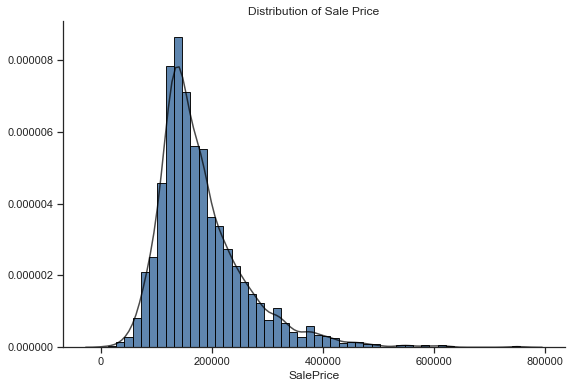

In [9]:
from statlearning import distplot
fig, ax  = distplot(data['SalePrice'])
ax.set_title('Distribution of Sale Price')
plt.show()

Because of the loss function, our response variable is in effect the log of the sale price. The log transformation makes the variable slightly left skewed, with one apparent outlier in the left tail. 

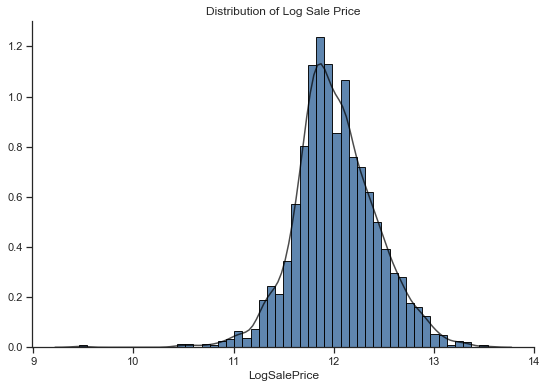

In [10]:
fig, ax  = distplot(data[response])
ax.set_title('Distribution of Log Sale Price')
plt.show()

The distribution of the ground living area is also right skewed, with some outliers in the right tail. That suggests that a tranformation may be helpful for this variable under certain models such as a linear regression. 

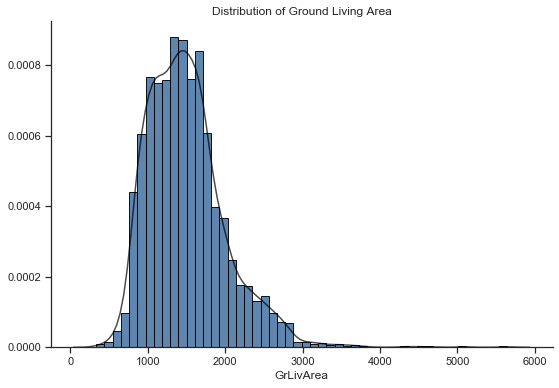

In [11]:
fig, ax  = distplot(data['GrLivArea'])
ax.set_title('Distribution of Ground Living Area')
plt.show()

Next, we plot the sale price against the ground living area. This is to illustrate that even if we had formulated the loss function on the original scale, this is a typical case in which we would want to transform the response variable in a linear regression to account for nonlinearity, stabilise the variance of the errors, and reduce non-Gaussianity. 

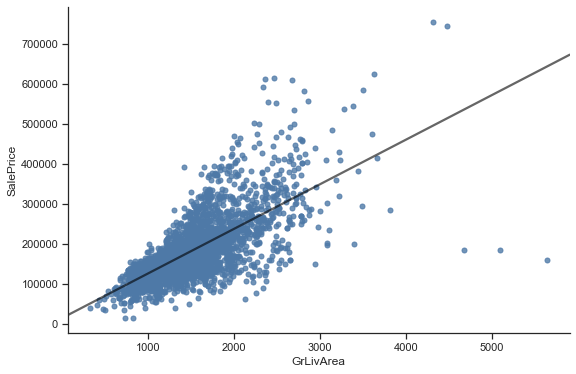

In [12]:
# doing this makes the rest of the cell reusable
y = 'SalePrice'
x = 'GrLivArea' 

fig, ax = plt.subplots()
sns.regplot(data[x], data[y], ci=None, scatter_kws={'s':25}, 
            line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel(x)
ax.set_ylabel(y)
sns.despine()
plt.show()

Plotting the log of the sale price against the ground living area suggests that this is a better specification. However, there still may be some nonlinearity, and there five outliers well below the regression line. 

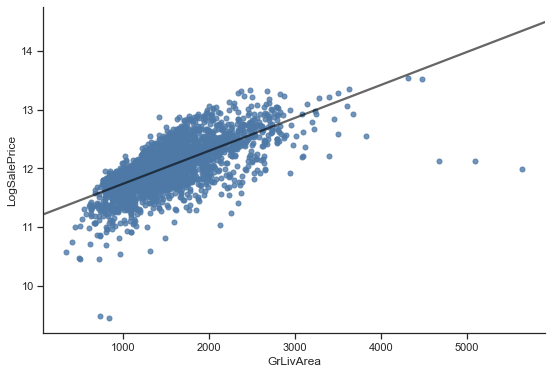

In [13]:
y = 'LogSalePrice'
x = 'GrLivArea' 

fig, ax = plt.subplots()
sns.regplot(data[x], data[y], ci=None, scatter_kws={'s':25},
            line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel(x)
ax.set_ylabel(y)
sns.despine()
plt.show()

### 4. Cleaning the Data

A dataset of this complexity is likely to have some errors. Hopefully, we should be able to detect these errors through EDA. Consider for example the following variable. 

In [14]:
data['GarageYrBlt'].describe().round(0)

count    2771.0
mean     1978.0
std        26.0
min      1895.0
25%      1960.0
50%      1979.0
75%      2002.0
max      2207.0
Name: GarageYrBlt, dtype: float64

The maximum value is a typing error which we are easily able to fix.

In [15]:
data['GarageYrBlt']
data.loc[data['GarageYrBlt']==2207, 'GarageYrBlt'] = 2007

### 5. Outliers

It's a good idea to examine the outliers early one. The ones is our data may be a problem because they are also leverage points (values in the tail of the distribution of the predictor). 

We can see that the three outliers with high ground living area were partial sales (see the penultimate column), which explains their low price. 

In [16]:
data[data['GrLivArea']> 4500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
1498,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,Gd,NaN,NaN,0,1,2008,New,Partial,160000,11.982929
2180,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,...,NaN,NaN,Elev,17000,10,2007,New,Partial,183850,12.121875
2181,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,NaN,NaN,NaN,0,10,2007,New,Partial,184750,12.126759


The other two outliers were abnormal sales. 

In [17]:
data[data['LogSalePrice']<10]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
181,30,RM,68.0,9656,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,6,2010,WD,Abnorml,12789,9.456341
1553,20,A (agr),80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Abnorml,13100,9.480368


Inspecting the data, we see that there are many partial and abnormal sales, so that we shouldn't completly dismiss those data points. 

In [18]:
data['SaleCondition'].value_counts()

Normal     2413
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64

The next cell shows how we can use the validation data to check if the outliers negatively impact predictive accuracy (there are four in the training data). They seem to make no difference for the current specification. However, we should check again when estimating a larger model with more predictors.

In [19]:
outliers = [181, 1498, 1553, 2180, 2181]

predictors = ['GrLivArea']

X_train = data.loc[index_train, predictors]
y_train  = data.loc[index_train, response]

X_val = data.loc[index_val, predictors]
y_val  = data.loc[index_val, response]

ols1 = LinearRegression()
ols1.fit(X_train, y_train)

indexes =  index_train[~index_train.isin(outliers)] # index labels which are NOT in the list of outliers
ols2 = LinearRegression()
ols2.fit(X_train.loc[indexes], y_train.loc[indexes])

# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['All observations', 'Without outliers']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols1, ols2] 

# Computer predictions
for i, method in enumerate(methods):
    y_pred = method.predict(X_val)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_val, y_pred))
    results.iloc[i, 1] = r2_score(y_val, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_val, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
All observations,0.314,0.434,0.232
Without outliers,0.314,0.432,0.232


### 6. Constructing Informative Predictors

As mentioned in the lecture, one of the most important tasks in feature engineering is to build informative features from the initial data. For example, our dataset we have information about when the house was built and when it was sold. Therefore, we construct a predictor called `Age`, which tells us the age of the house at the time of sale (in months). This is clearly a relevant factor in the price of the house. 

In [20]:
# Approximation since we don't know the month when the house was finished
data['Age'] = (data['YrSold']-data['YearBuilt'])*12 + data['MoSold'] - 1
variables.loc['Age', 'type'] = 'continuous' 
predictors.append('Age')

This is just one example – we always try to come up with interesting features based on domain knowledge and the data. 

### 7. Continuous Predictors

Above in the EDA, we found that the distribution of ground living price is right skewed (with some outliers), and that its relationship with the log of the sale price seems to depart slightly from linearity. We therefore consider a transformation of the predictor. 

The next cells fit a baseline model without transformation and shows you how to do the log, Box-Cox, and Yeo-Johnson transformations. 

In [21]:
predictors = ['GrLivArea']
y_val  = data.loc[index_val, response]
y_train  = data.loc[index_train, response]

# Without transformation
X_train1 = data.loc[index_train, predictors]
X_val1 = data.loc[index_val, predictors]
ols1 = LinearRegression()
ols1.fit(X_train1, y_train)

# Log transformation
X_train2 = np.log(data.loc[indexes, predictors])
X_val2 = np.log(data.loc[index_val, predictors])
ols2 = LinearRegression()
ols2.fit(X_train2, y_train[indexes])

from sklearn.preprocessing import PowerTransformer

# Box-Cox transformation
X_train3 = data.loc[index_train, predictors].copy() # copying the original data
boxcox = PowerTransformer(method='box-cox')
X_train3 = boxcox.fit_transform(X_train3) # we fit the transformation based on the training sample
X_val3 =  boxcox.transform(X_val1)
ols3 = LinearRegression()
ols3.fit(X_train3, y_train)

# Yeo-Johnson transformation
X_train4 = data.loc[index_train, predictors].copy()
yeoj = PowerTransformer(method='yeo-johnson') # making it explicit but YJ is actually the default
X_train4 = yeoj.fit_transform(X_train4)
X_val4 =  yeoj.transform(X_val1)
ols4 = LinearRegression()
ols4.fit(X_train4, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Comparing the four specifications on the validation data, we can see that the transforming the variable improves predictive accuracy. However, the log, Box-Cox and Yeo-Johnson lead to the same results in this case. The reason is that the fitted Box-Cox and Yeo-Johnson transformations were essentially log transformations. 

In [22]:
# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['No transformation', 'Log', 'Box-Cox', 'Yeo-Johnson']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols1, ols2, ols3, ols4] 
designs = [X_val1, X_val2, X_val3, X_val4] 

# Computer predictions
for i, (method, X_val) in enumerate(zip(methods, designs)):
    y_pred = method.predict(X_val)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_val, y_pred))
    results.iloc[i, 1] = r2_score(y_val, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_val, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
No transformation,0.314,0.434,0.232
Log,0.308,0.454,0.230
Box-Cox,0.308,0.455,0.230
Yeo-Johnson,0.308,0.455,0.230


It's interesting to inspect the distribution of the transformed predictor. We can see that it's nearly symmetric, without outliers.

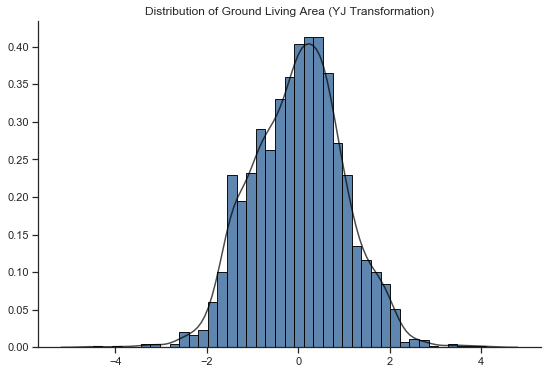

In [23]:
fig, ax  = distplot(X_train4)
ax.set_title('Distribution of Ground Living Area (YJ Transformation)')
plt.show()

### 8. Nominal Predictors

Let's consider the neighbourhood as an example. We start by inspecting the variable.

In [24]:
data['Neighborhood'].describe()

count      2930
unique       28
top       NAmes
freq        443
Name: Neighborhood, dtype: object

In [25]:
data['Neighborhood'].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

The first detail that we note is that some neighbourhoods have very few observations. Therefore, we merge them into an "other" category.  The cut-off is arbitrary.

In [26]:
variable = 'Neighborhood' # this is to make the rest of the code reusable

counts = data[variable].value_counts() 
for level in counts.index:
    if counts[level] < 10:
        data.loc[data[variable]==level, variable] = 'Other'

The next cell shows you how to one-hot encode the nominal variable. 

In [27]:
variable = 'Neighborhood'
dummies = pd.get_dummies(data[variable],  prefix = variable)
dummies.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Since we need dummy encoding for the linear regression model, we add the `drop_first=True` to remove one of the columns.  We then merge the dummies into the original dataframe and update the list of predictors. 

In [28]:
variable = 'Neighborhood'
dummies = pd.get_dummies(data[variable],  prefix = variable, drop_first=True)
data = data.join(dummies)
predictors += list(dummies.columns) 

### 9. Ordinal Predictors

Let's look at the overall quality variable.

In [29]:
data['OverallQual'].value_counts().sort_index()

1       4
2      13
3      40
4     226
5     825
6     732
7     602
8     350
9     107
10     31
Name: OverallQual, dtype: int64

The first level has very few observations, so that we merge it into the next one. 

In [30]:
data.loc[data['OverallQual']== 1, 'OverallQual'] = 2

The standard approach for an ordinal variable in linear regression is to treat it as nominal variable, which makes us lose the information from the ordering of the categories. 

In [31]:
variable = 'OverallQual'
dummies = pd.get_dummies(data[variable],  prefix = variable, drop_first=True)
data = data.join(dummies)
predictors += list(dummies.columns) 

Now, consider the kitchen quality.

In [32]:
data['KitchenQual'].value_counts()

TA    1494
Gd    1160
Ex     205
Fa      70
Po       1
Name: KitchenQual, dtype: int64

Here's how to do ordinal encoding, which we can be useful for preliminary analysis and tree-based methods. 

In [33]:
keys = {
        'Po': 1, # poor, noting that we could already merge it with fair here
        'Fa': 2, # fair
        'TA': 3, # typical/average
        'Gd': 4, # good
        'Ex': 5, # excellent
}

variable = 'KitchenQual'
data[variable] = data[variable].replace(keys)

### 10. Missing Values

To simplify the analysis, we restrict attention to continuous predictors. 

In [34]:
continuous = sorted(list(variables[variables['type']=='continuous'].index))
print(continuous)

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Age', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']


We check for missing values as follows. 

In [35]:
data[continuous].isnull().sum()

1stFlrSF           0
2ndFlrSF           0
3SsnPorch          0
Age                0
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
EnclosedPorch      0
GarageArea         1
GarageYrBlt      159
GrLivArea          0
LotArea            0
LotFrontage      490
LowQualFinSF       0
MasVnrArea        23
MiscVal            0
OpenPorchSF        0
PoolArea           0
ScreenPorch        0
TotalBsmtSF        1
WoodDeckSF         0
YearBuilt          0
YearRemodAdd       0
dtype: int64

Consider the year in which the garage was built (we could also create an age variable as above). Inspecting the data reveals that the missing values are due to the fact that the house does not have a garage. We therefore create a binary variable to indicate this scenario, and replace the missing values in `GarageYrBlt` with zeros (the imputation does not affect the regression in the presence of the binary variable).

In [36]:
data['GarageNA'] = data['GarageYrBlt'].isnull().astype(int)
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

### 11. Predictors with Many Zeros

Several predictors in this dataset have many zeros, typically because they are not applicable to certain houses. We also observe missing values in these cases, like in the previous section. 

Consider for example the size of the second floor. If we use this variable in isolation, it's clear that the zeros prevent us from fitting the non-zeros accurately using a simple linear regression. 

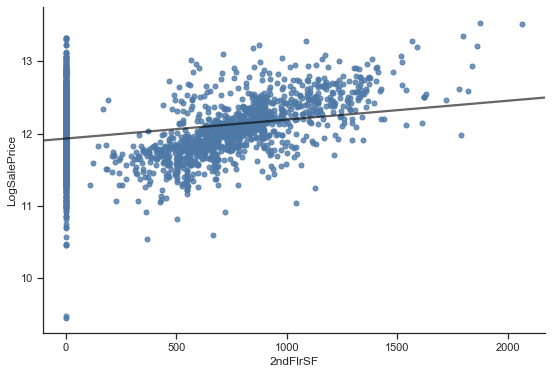

In [37]:
y = 'LogSalePrice'
x = '2ndFlrSF' 

fig, ax = plt.subplots()
sns.regplot(data[x], data[y], ci=None, scatter_kws={'s':25},
            line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel(x)
ax.set_ylabel(y)
sns.despine()
plt.show()

To solve this problem, create a binary variable to indicate a value of zero. Clearly, these houses are a case apart from the ones that have a second floor.

In [38]:
data['2ndFlrNA'] = (data['2ndFlrSF']==0).astype(int)

We can use the validation data to verify that this greatly improves the model. 

In [39]:
y_train  = data.loc[index_train, response]

subset1 =  ['2ndFlrSF']
subset2 = subset1[:] + ['2ndFlrNA']

# Without dummy
X_train1 = data.loc[index_train, subset1]
X_val1 = data.loc[index_val, subset1]
ols1 = LinearRegression()
ols1.fit(X_train1, y_train)

# With dummy
X_train2 = data.loc[index_train, subset2]
X_val2 = data.loc[index_val, subset2]
ols2 = LinearRegression()
ols2.fit(X_train2, y_train)

# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Without dummy', 'With dummy']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols1, ols2] 
designs = [X_val1, X_val2] 

# Computer predictions
for i, (method, X_val) in enumerate(zip(methods, designs)):
    y_pred = method.predict(X_val)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_val, y_pred))
    results.iloc[i, 1] = r2_score(y_val, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_val, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
Without dummy,0.409,0.041,0.306
With dummy,0.381,0.167,0.275


*Note: this ends up not making much difference for this particular variable when estimating a larger model, but the only way to know is to experiment.*

The next cell shows how adding the dummy variable for the zeros allows the regression to fit the non-zeros properly. 

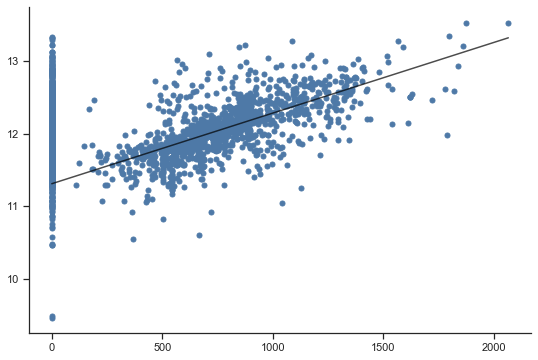

In [40]:
n = len(index_train)

# Grid of values for '2ndFlrSF'
x = np.array([data['2ndFlrSF'].min(), data['2ndFlrSF'].max()]).reshape((-1,1))

# First column: 2ndFlrSF (from the grid), second column: all zeros (because we want 2ndFlrNA=0)
X_grid = np.c_[x, np.zeros((len(x),1))] # np.c_ concatenates columns

# Fitted values
y_fitted = ols2.predict(X_grid)

fig, ax = plt.subplots()
ax.scatter(data['2ndFlrSF' ], data['LogSalePrice'], s=25)
ax.plot(x, y_fitted, color='black', alpha = 0.7)
sns.despine()
plt.show()

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [41]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [42]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')